**PROBLEM STATEMENT**
<br/>Predict the Active Covid cases of 2021 depending on 2020 statewise data in India. 
<br/>Get Sample data from Source- https://www.kaggle.com/aritranandi23/covid-19-analysis-and-prediction/data
<br/>
<br/>**COLUMN DEFINITION**
<br/>Date:string
<br/>Time:string
<br/>State/UnionTerritory:string
<br/>ConfirmedIndianNational:string
<br/>ConfirmedForeignNational:string
<br/>Cured:integer
<br/>Deaths:integer
<br/>Confirmed:integer

<br/>**STEPS IN MODELLING**
<br/>1.Data Acquisation
<br/>2.Data understanding
<br/>3.Data visualisation/EDA
<br/>4.Data cleaning/missing imputation/typecasting
<br/>5.Sampling/ bias removal
<br/>6.Anomaly detection
<br/>7.Feature selection/importance
<br/>8.Azure ML Model trigger
<br/>9.Model Interpretation
<br/>10.Telemetry
<br/>
<br/>
<br/>**FEATURE ENGINEERING**
<br/>1.Get Death rates, Discharge rates, Active cases rates from Confirmed, Cured, Death cases 
<br/>2.In TS Forecasting each group must provide atleast 3 datapoints to obtain frequency, remove the records where frequency<=3 for the train set i.e. data from the year 2020

## Import functions from Master Notebook:
Import the Functions and dependencies from the Master notebook to be used in the Trigger Notebook

In [0]:
%run /Users/.../AMLMasterNotebook

## 1.Data Acquisition
1.Acquisition of data from datasource ADLS path in CSV/Parquet/JSON etc format.
<br/>2.Logical Transformations in data. 
<br/>3.Transforming columns into required datatypes, converting to pandas df, persisiting actual dataset, intoducing a column 'Index' to assign a unique identifier to each dataset row so that this canm be used to retrieve back the original form after any data manupulations.

In [0]:
%scala
//<USER INPUT FILEPATH PARQUET OR CSV>

val filepath1= "adl://psinsightsadlsdev01.azuredatalakestore.net/Temp/ML-PJC/covid_19_india.csv"
var df1=spark.read.format("com.databricks.spark.csv").option("inferSchema", "true").option("header", "true").option("delimiter", ",").load(filepath1)
df1.createOrReplaceTempView("CovidIndia")



val filepath2= "adl://psinsightsadlsdev01.azuredatalakestore.net/Temp/ML-PJC/covid_vaccine_statewise.csv"
var df2=spark.read.format("com.databricks.spark.csv").option("inferSchema", "true").option("header", "true").option("delimiter", ",").load(filepath2)
df2.createOrReplaceTempView("Vaccine")

val filepath3= "adl://psinsightsadlsdev01.azuredatalakestore.net/Temp/ML-PJC/StatewiseTestingDetails.csv"
var df3=spark.read.format("com.databricks.spark.csv").option("inferSchema", "true").option("header", "true").option("delimiter", ",").load(filepath3)
df3.createOrReplaceTempView("Testing")



In [0]:
%sql
with CTE1 as
(select
MAX(date_format(Date, 'MMMM')) AS Month
,MAX(Year(Date)) AS Year
,CONCAT(Year(Date),'-',RIGHT(CONCAT('00',MONTH(Date)),2),'-','01') AS Date
,`State/UnionTerritory` as State
,SUM(Cured) as Cured
,SUM(Deaths) as Deaths
,SUM(Confirmed) as Confirmed
,((SUM(Confirmed)-SUM(Deaths)-SUM(Cured))/SUM(Confirmed) * 100) as ActiveCasesRate
,(SUM(Cured)/SUM(Confirmed) * 100) AS DischargeRate
,(SUM(Deaths)/SUM(Confirmed) * 100) as DeathsRate
from CovidIndia C
group by 
CONCAT(Year(Date),'-',RIGHT(CONCAT('00',MONTH(Date)),2),'-','01')
,`State/UnionTerritory`
)

--select distinct state from CTE1 group by State having count(*)<=3
select * from CTE1 where State not in (select distinct state from CTE1 group by State having count(*)<=3)
and Year=2021

Month Year Date State Cured Deaths Confirmed ActiveCasesRate DischargeRate DeathsRate January 2021 2021-01-01 Andaman and Nicobar Islands 151473 1922 154187 0.5136619818791467 98.23979972371212 1.2465382944087375 January 2021 2021-01-01 Andhra Pradesh 27160550 221186 27448884 0.2446292534151844 98.94956020798514 0.805810538599675 January 2021 2021-01-01 Arunachal Pradesh 516950 1736 520415 0.3322348510323492 99.33418521756676 0.3335799314009012 January 2021 2021-01-01 Assam 6600118 33089 6718515 1.2697448766580115 98.23775045527174 0.4925046680702506 January 2021 2021-01-01 Bihar 7800177 44922 7952001 1.3443408772207146 98.0907447068983 0.5649144158809839 January 2021 2021-01-01 Chandigarh 615729 10173 632798 1.0897632419824337 97.30261473645618 1.607622021561383 January 2021 2021-01-01 Chhattisgarh 8712058 109600 9047658 2.4978839827942214 96.29075281139052 1.2113632058152508 January 2021 2021-01-01 Dadra and Nagar Haveli and Daman and Diu 104703 62 104994 0.21810770139246055 99.72284130521743 0.05905099339009848 January 2021 2021-01-01 Delhi 19139813 332233 19566622 0.4833537439421071 97.8186883765629 1.697957879494989 January 2021 2021-01-01 Goa 1569499 23325 1619005 1.6171043325993433 96.94219597839414 1.4406996890065196 January 2021 2021-01-01 Gujarat 7537895 134971 7880572 2.6356716238364424 95.65162275022676 1.7127056259367972 January 2021 2021-01-01 Haryana 8074769 92110 8233403 0.8079769689398174 98.07328755801215 1.1187354730480217 January 2021 2021-01-01 Himachal Pradesh 1696881 29793 1756015 1.6708854992696531 96.63248890242964 1.6966255983006977 January 2021 2021-01-01 Jammu and Kashmir 3701427 59336 3813238 1.3761270605191702 97.06782005214465 1.5560528873361694 January 2021 2021-01-01 Jharkhand 3564069 32574 3633956 1.026787335895096 98.07683417190522 0.8963784921996855 January 2021 2021-01-01 Karnataka 28192578 376925 28833752 0.9164572130605826 97.7763074330389 1.3072353539005261 January 2021 2021-01-01 Kerala 23797725 105654 26008754 8.094870673158736 91.49890456113353 0.40622476570773053 January 2021 2021-01-01 Ladakh 290444 3969 298640 1.4154165550495579 97.25555853201179 1.3290249129386553 January 2021 2021-01-01 Lakshadweep 44 0 702 93.73219373219374 6.267806267806268 0.0 January 2021 2021-01-01 Madhya Pradesh 7434380 115640 7747005 2.5427245754972407 95.96456953364559 1.4927058908571764 January 2021 2021-01-01 Maharashtra 58313365 1559536 61433195 2.5398223224431025 94.92158921573264 2.5385884618242627 January 2021 2021-01-01 Manipur 865323 11322 890695 1.5774198799813628 97.15143792207209 1.2711421979465474 January 2021 2021-01-01 Meghalaya 414228 4445 422833 0.983839955727202 97.96491759157871 1.0512424526940896 January 2021 2021-01-01 Mizoram 130882 269 133505 1.7632298415789671 98.0352795775439 0.2014905808771207 January 2021 2021-01-01 Nagaland 366315 2635 372584 0.9753505249822859 98.31742640585746 0.707223069160243 January 2021 2021-01-01 Odisha 10199711 58761 10312437 0.5233001665852601 98.90689271604762 0.569807117367117 January 2021 2021-01-01 Puducherry 1166654 19844 1196248 0.815048384615899 97.52609826724893 1.6588533481351693 January 2021 2021-01-01 Punjab 5015847 169959 5263530 1.4766516007318282 95.29435568905278 3.2289927102153877 January 2021 2021-01-01 Rajasthan 9476841 84943 9733025 1.7593810762840945 97.36788922251817 0.8727297011977263 January 2021 2021-01-01 Sikkim 173952 4040 186334 4.476907059366514 93.354943273906 2.1681496667274893 January 2021 2021-01-01 Tamil Nadu 25122063 379745 25697977 0.7633635908382983 97.75891308487046 1.4777233242912466 January 2021 2021-01-01 Telengana 8847617 48803 9024439 1.4185812547461398 98.04063166696567 0.5407870782881905 January 2021 2021-01-01 Tripura 1019367 12063 1032922 0.14444459504202642 98.68770342775156 1.1678519772064107 January 2021 2021-01-01 Uttar Pradesh 17870678 264524 18433015 1.6156499628519807 96.94929451313308 1.4350555240149265 January 2021 2021-01-01 Uttarakhand 2787733 49344 2918219 2.780531550236634 95.52857410632993 1.69

In [0]:
df= spark.sql("""
with CTE1 as
(select
MAX(date_format(Date, 'MMMM')) AS Month
,MAX(Year(Date)) AS Year
,CONCAT(Year(Date),'-',RIGHT(CONCAT('00',MONTH(Date)),2),'-','01') AS Date
,`State/UnionTerritory` as State
,SUM(Cured) as Cured
,SUM(Deaths) as Deaths
,SUM(Confirmed) as Confirmed
,((SUM(Confirmed)-SUM(Deaths)-SUM(Cured))/SUM(Confirmed) * 100) as ActiveCasesRate
,(SUM(Cured)/SUM(Confirmed) * 100) AS DischargeRate
,(SUM(Deaths)/SUM(Confirmed) * 100) as DeathsRate
from CovidIndia C
group by 
CONCAT(Year(Date),'-',RIGHT(CONCAT('00',MONTH(Date)),2),'-','01')
,`State/UnionTerritory`
)

select * from CTE1 
where State not like 'Lakshadweep' and --Low Frequency for train as only one month dec in 2020 train
State not in (select distinct state from CTE1 group by State having count(*)<=3) --low frequency for train as atleast three months required """)

In [0]:
import pandas as pd
import numpy as np
from pyspark.sql.functions import col
##df.select(*(col(c).cast("float").alias(c) for c in df.columns))
#cols=df.columns
#cols.remove('Index')
#for col_name in cols:
#    df = df.withColumn(col_name, col(col_name).cast('float'))
#for col_name in ['Index']:
#    df = df.withColumn(col_name, col(col_name).cast('Int'))   

# <USER INPUT COLUMN NAMES WITH DATAYPES IN RESPECTIVE BUCKET>
cols_all=[
'Month'
,'Year'
,'Date'
,'State'
,'Cured'
,'Deaths'
,'Confirmed'
,'ActiveCasesRate'
,'DischargeRate'
,'DeathsRate'
]
cols_string=[
'Month'
,'Year'
,'Date'
,'State'
]
cols_int=[
'Cured'
,'Deaths'
,'Confirmed'
]
cols_bool=[]
cols_Float=[
'ActiveCasesRate'
,'DischargeRate'
,'DeathsRate'
]
for col_name in cols_int:
    df = df.withColumn(col_name, col(col_name).cast('Int'))  
for col_name in cols_Float:
    df = df.withColumn(col_name, col(col_name).cast('float')) 
for col_name in cols_bool:
    df = df.withColumn(col_name, col(col_name).cast('bool')) 
    
input_dataframe = df.toPandas()
input_dataframe['Index'] = np.arange(len(input_dataframe))
outdir = '/dbfs/FileStore/Covid.csv'
input_dataframe.to_csv(outdir, index=False)
#input_dataframe = pd.read_csv("/dbfs/FileStore/Dataframe.csv", header='infer')


## 2.Data Exploration
1.Exploratory Data Analysis (EDA)- To understand the overall data at hand, analysing each feature independently for its' statistics, the correlation and interraction between variables, data sample etc. 
<br/>2.Data Profiling Plots- To analyse the Categorical and Numerical columns separately for any trend in data, biasness in data etc.

In [0]:
input_dataframe = pd.read_csv("/dbfs/FileStore/Covid.csv", header='infer')

p=Data_Profiling_viaPandasProfiling(input_dataframe,'RealEstate','EDA')
displayHTML(p)


Summarize dataset: 0%| | 0/23 [00:00<?, ?it/s]Summarize dataset: 0%| | 0/23 [00:00<?, ?it/s, Describe variable:Month]Summarize dataset: 4%|▍ | 1/23 [00:00<00:03, 6.43it/s, Describe variable:Month]Summarize dataset: 4%|▍ | 1/23 [00:00<00:03, 6.43it/s, Describe variable:Year] Summarize dataset: 9%|▊ | 2/23 [00:00<00:03, 6.43it/s, Describe variable:State]Summarize dataset: 13%|█▎ | 3/23 [00:00<00:03, 6.43it/s, Describe variable:Date] Summarize dataset: 17%|█▋ | 4/23 [00:00<00:02, 6.43it/s, Describe variable:Cured]Summarize dataset: 22%|██▏ | 5/23 [00:00<00:02, 6.43it/s, Describe variable:ActiveCasesRate]Summarize dataset: 26%|██▌ | 6/23 [00:00<00:02, 6.43it/s, Describe variable:Confirmed] Summarize dataset: 30%|███ | 7/23 [00:00<00:00, 30.40it/s, Describe variable:Confirmed]Summarize dataset: 30%|███ | 7/23 [00:00<00:00, 30.40it/s, Describe variable:Deaths] Summarize dataset: 35%|███▍ | 8/23 [00:00<00:00, 30.40it/s, Describe variable:DischargeRate]Summarize dataset: 39%|███▉ | 9/23 [00:00<00:00, 30.40it/s, Describe variable:DeathsRate] Summarize dataset: 43%|████▎ | 10/23 [00:00<00:00, 30.40it/s, Get variable types] Summarize dataset: 48%|████▊ | 11/23 [00:00<00:00, 30.40it/s, Calculate pearson correlation]Summarize dataset: 52%|█████▏ | 12/23 [00:00<00:00, 30.40it/s, Calculate spearman correlation]Summarize dataset: 57%|█████▋ | 13/23 [00:00<00:00, 30.40it/s, Calculate kendall correlation] Summarize dataset: 61%|██████ | 14/23 [00:00<00:00, 30.40it/s, Calculate phi_k correlation] Summarize dataset: 65%|██████▌ | 15/23 [00:02<00:01, 6.22it/s, Calculate phi_k correlation]Summarize dataset: 65%|██████▌ | 15/23 [00:02<00:01, 6.22it/s, Calculate cramers correlation]Summarize dataset: 70%|██████▉ | 16/23 [00:02<00:01, 6.22it/s, Get scatter matrix] Summarize dataset: 74%|███████▍ | 17/23 [00:09<00:00, 6.22it/s, Get table statistics]Summarize dataset: 78%|███████▊ | 18/23 [00:09<00:03, 1.31it/s, Get table statistics]Summarize dataset: 78%|███████▊ | 18/23 [00:09<00:03, 1.31it/s, Get missing diagrams]Summarize dataset: 83%|████████▎ | 19/23 [00:10<00:03, 1.31it/s, Take sample] Summarize dataset: 87%|████████▋ | 20/23 [00:10<00:02, 1.41it/s, Take sample]Summarize dataset: 87%|████████▋ | 20/23 [00:10<00:02, 1.41it/s, Locating duplicates]Summarize dataset: 91%|█████████▏| 21/23 [00:10<00:01, 1.41it/s, Get messages/warnings]Summarize dataset: 96%|█████████▌| 22/23 [00:10<00:00, 1.41it/s, Get reproduction details]Summarize dataset: 100%|██████████| 23/23 [00:10<00:00, 1.41it/s, Completed] Summarize dataset: 100%|██████████| 23/23 [00:10<00:00, 2.14it/s, Completed]
Generate report structure: 0%| | 0/1 [00:00<?, ?it/s]Generate report structure: 100%|██████████| 1/1 [00:06<00:00, 6.07s/it]Generate report structure: 100%|██████████| 1/1 [00:06<00:00, 6.08s/it]
Render HTML: 0%| | 0/1 [00:00<?, ?it/s]Render HTML: 100%|██████████| 1/1 [00:02<00:00, 2.14s/it]Render HTML: 100%|██████████| 1/1 [00:02<00:00, 2.14s/it]
Export report to file: 0%| | 0/1 [00:00<?, ?it/s]Export report to file: 100%|██████████| 1/1 [00:00<00:00, 9.06it/s]Export report to file: 100%|██████████| 1/1 [00:00<00:00, 9.03it/s]
EDA Report can be downloaded from path: adl://psinsightsadlsdev01.azuredatalakestore.net/DEV/EDAProfile_RealEstate.html

<!doctype html> Pandas Profiling Report Toggle navigation Pandas Profiling Report Overview Variables Interactions Correlations Missing values Sample Overview Overview Warnings 33 Reproduction Dataset statistics Number of variables 10 Number of observations 644 Missing cells 3 Missing cells (%) < 0.1% Duplicate rows 0 Duplicate rows (%) 0.0% Total size in memory 50.4 KiB Average record size in memory 80.2 B Variable types Categorical 4 Numeric 6 Warnings Year is highly correlated with ActiveCasesRate and 1 other fields High correlation Cured is highly correlated with Deaths and 1 other fields High correlation Deaths is highly correlated with Cured and 1 other fields High correlation Confirmed is highly correlated with Cured and 1 other fields High correlation ActiveCasesRate is highly correlated with Year and 1 other fields High correlation DischargeRate is highly correlated with Year and 1 other fields High correlation Year is highly correlated with ActiveCasesRate and 1 other fields High correlation Cured is highly correlated with Deaths and 3 other fields High correlation Deaths is highly correlated with Cured and 3 other fields High correlation Confirmed is highly correlated with Cured and 3 other fields High correlation ActiveCasesRate is highly correlated with Year and 4 other fields High correlation DischargeRate is highly correlated with Year and 4 other fields High correlation Year is highly correlated with ActiveCasesRate and 1 other fields High correlation Cured is highly correlated with Deaths and 1 other fields High correlation Deaths is highly correlated with Cured and 1 other fields High correlation Confirmed is highly correlated with Cured and 1 other fields High correlation ActiveCasesRate is highly correlated with Year and 1 other fields High correlation DischargeRate is highly correlated with Year and 1 other fields High correlation Year is highly correlated with Date and 3 other fields High correlation Date is highly correlated with Year and 3 other fields High correlation ActiveCasesRate is highly correlated with Year and 3 other fields High correlation Deaths is highly correlated with Cured and 1 other fields High correlation Cured is highly correlated with Deaths and 1 other fields High correlation Confirmed is highly correlated with Deaths and 1 other fields High correlation Month is highly correlated with Year and 3 other fields High correlation DischargeRate is highly correlated with Year and 3 other fields High correlation Year is highly correlated with Date and 1 other fields High correlation Date is highly correlated with Year and 1 other fields High correlation Month is highly correlated with Year and 1 other fields High correlation Cured has 27 (4.2%) zeros Zeros Deaths has 55 (8.5%) zeros Zeros DischargeRate has 26 (4.0%) zeros Zeros DeathsRate has 54 (8.4%) zeros Zeros Reproduction Analysis started 2021-08-29 07:32:29.979039 Analysis finished 2021-08-29 07:32:40.750773 Duration 10.77 seconds Software version pandas-profiling v3.0.0 Download configuration <a download=config.json href="data:text/plain;charset=utf-8,%7B%22title%22%3A%20%22Pandas%20Profiling%20Report%22%2C%20%22dataset%22%3A%20%7B%22description%22%3A%20%22%22%2C%20%22creator%22%3A%20%22%22%2C%20%22author%22%3A%20%22%22%2C%20%22copyright_holder%22%3A%20%22%22%2C%20%22copyright_year%22%3A%20%22%22%2C%20%22url%22%3A%20%22%22%7D%2C%20%22variables%22%3A%20%7B%22descriptions%22%3A%20%7B%7D%7D%2C%20%22infer_dtypes%22%3A%20true%2C%20%22show_variable_description%22%3A%20true%2C%20%22pool_size%22%3A%200%2C%20%22progress_bar%22%3A%20true%2C%20%22vars%22%3A%20%7B%22num%22%3A%20%7B%22quantiles%22%3A%20%5B0.05%2C%200.25%2C%200.5%2C%200.75%2C%200.95%5D%2C%20%22skewness_threshold%22%3A%2020%2C%20%22low_categorical_threshold%22%3A%205%2C%20%22chi_squared_threshold%22%3A%200.999%7D%2C%20%22cat%22%3A%20%7B%22length%22%3A%20true%2C%20%22characters%22%3A%20true%2C%20%22words%22%3A%20true%2C%20%22cardinality_threshold%22%3A%2050%2C%20%22n_obs%22%3A%205%2

Count plots to identify if any biasness due to data skewness in Categorical columns

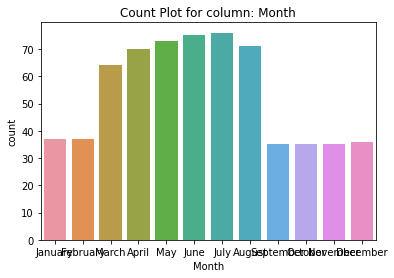

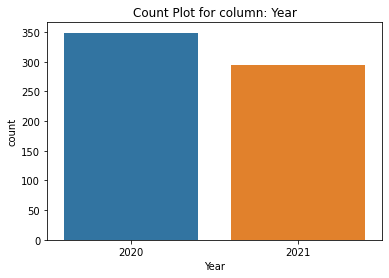

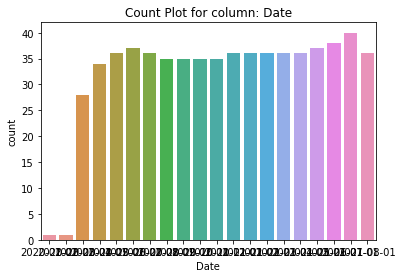

Box distribution plots to identify if any biasness of Categorical columns in determining label col

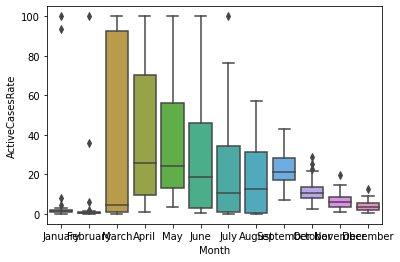

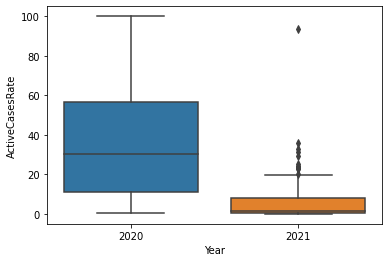

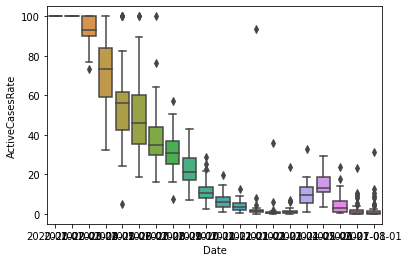

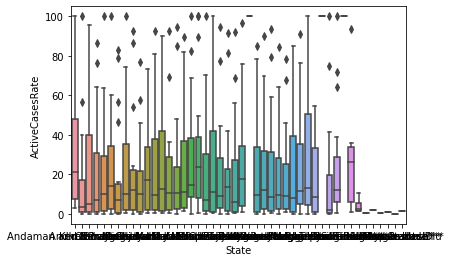

Distribution plots to identify if any biasness due to data skewness in Numerical columns

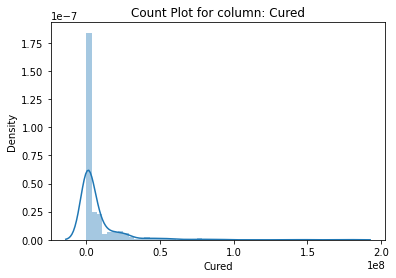

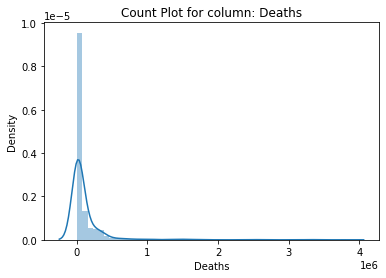

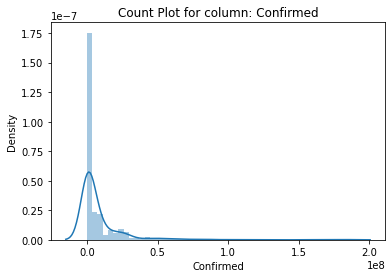

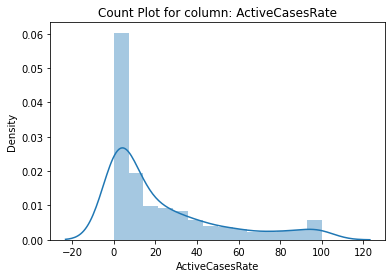

In [0]:
input_dataframe = pd.read_csv("/dbfs/FileStore/Covid.csv", header='infer')

#User Inputs
cols_all=[
'Month'
,'Year'
,'Date'
,'State'
,'Cured'
,'Deaths'
,'Confirmed'
,'ActiveCasesRate'
,'DischargeRate'
,'DeathsRate'
]
Categorical_cols=['Month'
,'Year'
,'Date'
,'State'
]
Numeric_cols=['Cured'
,'Deaths'
,'Confirmed'
,'ActiveCasesRate'
,'DischargeRate'
,'DeathsRate'
]
Label_col='ActiveCasesRate'

#Data_Profiling_Plots(input_dataframe,Categorical_cols,Numeric_cols,Label_col)
Data_Profiling_Plots(input_dataframe,Categorical_cols,Numeric_cols,Label_col)

## 4.Cleansing
To clean the data from NULL values, fix structural errors in columns, drop empty columns, encode the categorical values, normalise the data to bring to the same scale. We also check the Data Distribution via Correlation heatmap of original input dataset v/s the Cleansed dataset to validate whether or not the transformations hampered the original data trend/density.

In [0]:
subsample_final = pd.read_csv("/dbfs/FileStore/Covid.csv", header='infer')
#subsample_final=subsample_final.drop(['Index'], axis = 1) # Index is highest variability column hence always imp along PC but has no business value. You can append columns to be dropped by your choice here in the list

inputdf_new=autodatacleaner(subsample_final,"/dbfs/FileStore/Covid.csv","Covid","Data Cleanser")
print("Total rows in the new pandas dataframe:",len(inputdf_new.index))

#persist cleansed data sets 
filepath1 = '/dbfs/FileStore/Cleansed_Covid.csv'
inputdf_new.to_csv(filepath1, index=False)


Impute/Drop NULL Rows:
Total rows in the Input dataframe: 623
Total number of cells in the input dataframe: 6853
Displaying number of missing records per column:
Month 0
Year 0
Date 0
State 0
Cured 0
Deaths 0
Confirmed 0
ActiveCasesRate 0
DischargeRate 0
DeathsRate 0
Index 0
dtype: int64
Total no. of missing values= 0
The dataset contains 0.0 % missing values.

 Categorical columns cleansing:
Fixing inconsistent capitalization and removing any white spaces.
Label Encoding on categorical columns.
MinMax scaling for Normalisation.
Total rows in the new pandas dataframe: 623

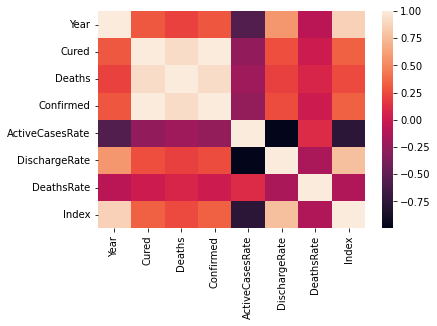

In [0]:
subsample_final = pd.read_csv("/dbfs/FileStore/Covid.csv", header='infer')

display(Data_Profiling_Fin(subsample_final))

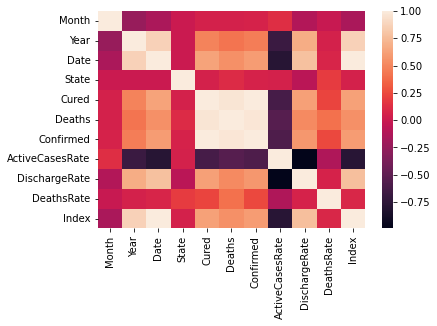

In [0]:
Cleansed=pd.read_csv("/dbfs/FileStore/Cleansed_Covid.csv", header='infer')

display(Data_Profiling_Fin(Cleansed))

## 5.Anomaly Detection
Iterate data over various Anomaly-detection techniques and estimate the number of Inliers and Outliers for each.

In [0]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager
from pyod.models.abod import ABOD
from pyod.models.knn import KNN
from pyod.utils.data import generate_data, get_outliers_inliers
from pyod.models.cblof import CBLOF
#from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from sklearn.preprocessing import MinMaxScaler
import warnings
from io import BytesIO
from pyspark.sql.functions import base64
from pyspark.sql.functions import unbase64
warnings.filterwarnings("ignore")
outliers_fraction = 0.05
#df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
#target_variable = 'SalePrice'
#variables_to_analyze = '1stFlrSF'
output_path = '/dbfs/FileStore/AnomalyDetection_HTML'
#df.plot.scatter('1stFlrSF','SalePrice')
def AnomalyDetection(df,target_variable,variables_to_analyze,outliers_fraction,input_appname,task_type):
    import time
    from datetime import date
    today = date.today()
    ts = int(time.time())
    appname = input_appname
    appnamequotes = "'%s'" % appname
    tsquotes = "'%s'" % str(ts)
    task = "'%s'" % str(task_type)
    
    #Scale the data is required to create a explainable visualization (it will become way too stretched otherwise)
    scaler = MinMaxScaler(feature_range=(0, 1))
    df[[target_variable,variables_to_analyze]] = scaler.fit_transform(df[[target_variable,variables_to_analyze]])
    X1 = df[variables_to_analyze].values.reshape(-1,1)
    X2 = df[target_variable].values.reshape(-1,1)
    X = np.concatenate((X1,X2),axis=1)
    random_state = np.random.RandomState(42)
    # Define seven outlier detection tools to be compared
    classifiers = {
        'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
        'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
        #'Feature Bagging':FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,check_estimator=False,random_state=random_state),
        'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
        'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
        'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
        'Average KNN': KNN(method='mean',contamination=outliers_fraction)
    }
    xx , yy = np.meshgrid(np.linspace(0,1 , 200), np.linspace(0, 1, 200))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        clf.fit(X)
        # predict raw anomaly score
        scores_pred = clf.decision_function(X) * -1
        # prediction of a datapoint category outlier or inlier
        y_pred = clf.predict(X)
        n_inliers = len(y_pred) - np.count_nonzero(y_pred)
        n_outliers = np.count_nonzero(y_pred == 1)
        X2
        # copy of dataframe
        dfx = df
        dfy=df
        dfx['outlier'] = y_pred.tolist()
        dfy['outlier'] = y_pred.tolist()
        dfy['scores_pred'] = scores_pred.tolist()
        dfy[target_variable] = df[target_variable]
        

        clf_name_string="%s" % str(clf_name)
        ts_string="%s" % str(ts)
        #OutputfileName="adl://psinsightsadlsdev01.azuredatalakestore.net/DEV/AnomalyDetection_"+clf_name_string +".csv"
        #copydbfs = '/dbfs/FileStore/AnomalyDetection.csv'
        #dfy.to_csv(copydbfs, index=False)
        #dbutils.fs.cp ("/FileStore/AnomalyDetection.csv", OutputfileName, True) 
        n_outliers="%s" % str(n_outliers)
        n_inliers="%s" % str(n_inliers)
        rm_str3 = "Insert into AutoTuneML.amltelemetry values (" + appnamequotes + ","+ task + ",'OUTLIERS :" + n_outliers + "  INLIERS :" + n_inliers  + "  :- " + clf_name+ "'," + tsquotes + ")"
        #spark.sql(rm_str3)
        is_outlier =  dfy['outlier']==1
        Outlier_data = dfy[is_outlier]
        html_data = Outlier_data.to_html(classes='table table-striped')
        # IX1 - inlier feature 1,  IX2 - inlier feature 2
        IX1 =  np.array(dfx[variables_to_analyze][dfx['outlier'] == 0]).reshape(-1,1)
        IX2 =  np.array(dfx[target_variable][dfx['outlier'] == 0]).reshape(-1,1)
        # OX1 - outlier feature 1, OX2 - outlier feature 2
        OX1 =  dfx[variables_to_analyze][dfx['outlier'] == 1].values.reshape(-1,1)
        OX2 =  dfx[target_variable][dfx['outlier'] == 1].values.reshape(-1,1) 
        print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        # threshold value to consider a datapoint inlier or outlier
        threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
        # decision function calculates the raw anomaly score for every point
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
        Z = Z.reshape(xx.shape)
        plt.figure(figsize=(10, 10))
        # fill blue map colormap from minimum anomaly score to threshold value
        plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        # draw red contour line where anomaly score is equal to thresold
        a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
        plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
        b = plt.scatter(IX1,IX2, c='white',s=20, edgecolor='k')
        c = plt.scatter(OX1,OX2, c='black',s=20, edgecolor='k')
        plt.axis('tight')  
        # loc=2 is used for the top left corner 
        plt.legend(
            [a.collections[0], b,c],
            ['learned decision function', 'inliers','outliers'],
            prop=matplotlib.font_manager.FontProperties(size=20),
            loc=2)
        plt.xlim((0, 1))
        plt.ylim((0, 1))
        plt.title(clf_name)
        #tmpfile = BytesIO()
        #plt.savefig(tmpfile, format='png')
        #plt.savefig('/dbfs/FileStore/figure.png')
        plt.show()        
       # encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')
       # print("done2")
        #text = 'OUTLIERS : '+ str(n_outliers)+', INLIERS : '+str(n_inliers)
        #clf_text = clf_name
        #output_file = "adl://psinsightsadlsdev01.azuredatalakestore.net/DEV/AnomalyDetection_chart" + clf_text + '.html'
        #html = '<h1 style="text-align: center;">{clf_text}</h1><h3 style="text-align: center;">{text}</h3><p><img style="display: block; margin-left: auto; margin-right: auto;" src="/FileStore/figure.png" alt="Plot" /></p>'
        #print(html)
        
        #print(html2)
        #html3 = html2+html_data
        #s = Template(html).safe_substitute(clf_text=clf_text)
        #t = Template(s).safe_substitute(text=text)
        #print(t)
        #dbutils.fs.put("/dbfs/FileStore/anamolydetection.html", "Contents of my file")
        #dbutils.fs.cp ("/dbfs/FileStore/anamolydetection.html", output_file, True)
        #print(html3)
        #with open(output_file,'w') as f:
        #    f.write(t)
        
        #filepath="adl://psinsightsadlsdev01.azuredatalakestore.net/DEV/AnomalyDetection.html"
        ##plt.savefig(tmpfile, format='png')
        #plt.savefig('/dbfs/FileStore/AnomalyDetection.png')
        #dbutils.fs.cp ("/FileStore/AnomalyDetection.png", filepath, True)
        #print("Anomaly Detection Report can be downloaded from path: ",filepath)


OUTLIERS : 45 INLIERS : 599 Angle-based Outlier Detector (ABOD)

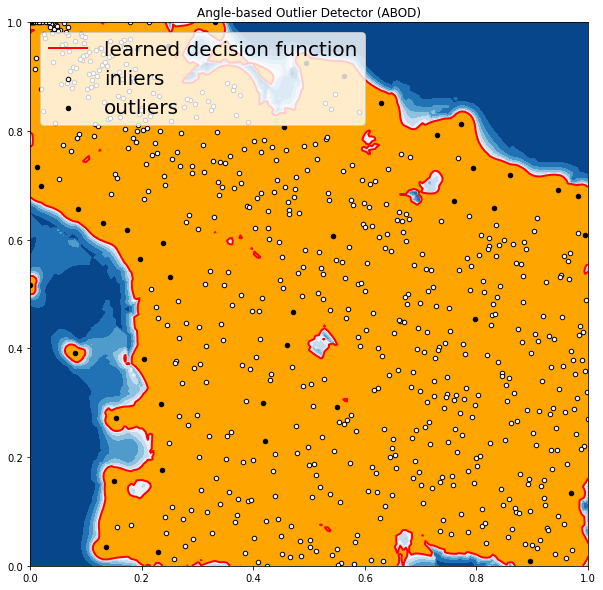

OUTLIERS : 33 INLIERS : 611 Cluster-based Local Outlier Factor (CBLOF)

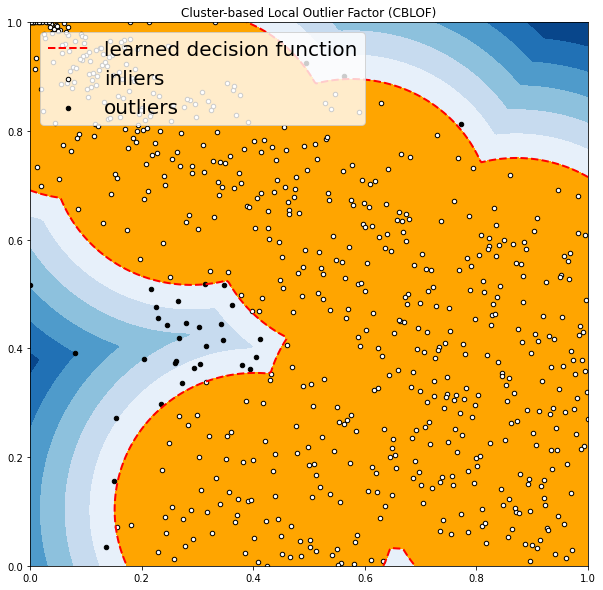

OUTLIERS : 21 INLIERS : 623 Histogram-base Outlier Detection (HBOS)

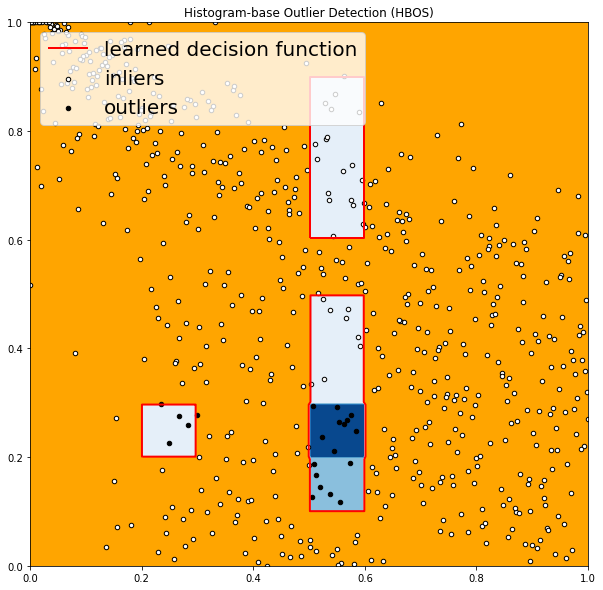

OUTLIERS : 33 INLIERS : 611 Isolation Forest

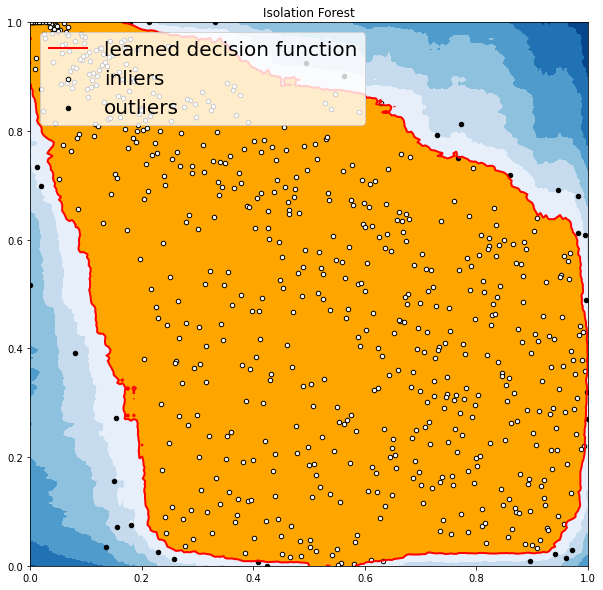

OUTLIERS : 23 INLIERS : 621 K Nearest Neighbors (KNN)

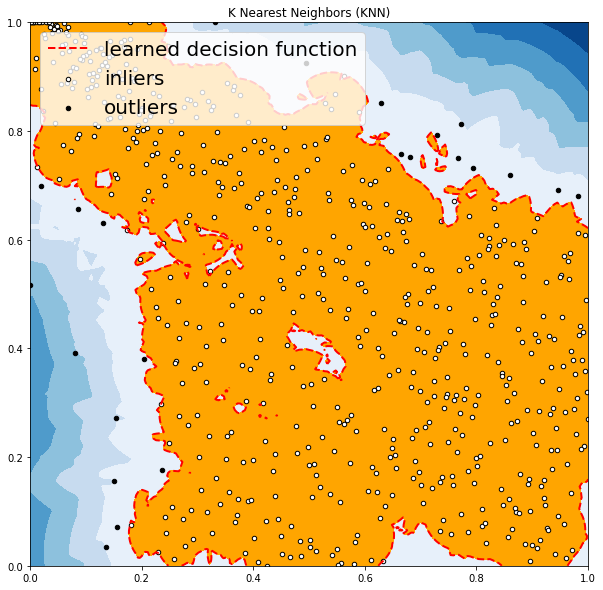

OUTLIERS : 10 INLIERS : 634 Average KNN

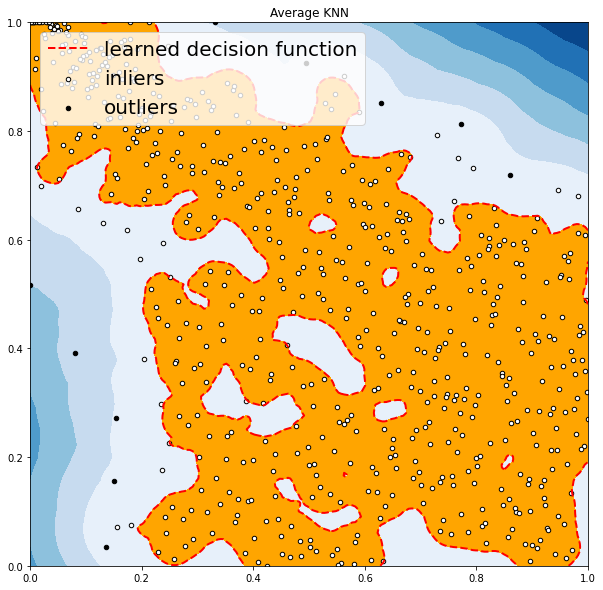

In [0]:
#Calling the Anamoly Detection Function for identifying outliers 
outliers_fraction = 0.05
df =pd.read_csv("/dbfs/FileStore/Cleansed_Covid.csv", header='infer')
target_variable = 'ActiveCasesRate'
variables_to_analyze='Confirmed'

AnomalyDetection(df,target_variable,variables_to_analyze,outliers_fraction,'anomaly_test','test')

## 6.Feature Selection
Perform feature selection on the basis of Feature Importance ranking, correlation values, variance within the column.
Choose features with High Importance value score, drop one of the two highly correlated features, drop features which offer zero variability to data and thus do not increase the entropy of dataset.

In [0]:
df =pd.read_csv("/dbfs/FileStore/Cleansed_Covid.csv", header='infer')
FeatureSelection(df,'ActiveCasesRate','Continuous',"/dbfs/FileStore/Cleansed_Covid.csv",'Covid','FeatureSelection')

*Fetures Selection based on Decision tree Regressor
Bagged decision trees like Random Forest and Decision Trees can be used to estimate the importance of features. Larger score the more important the attribute.
Feature Importance values: 
 DischargeRate 0.990373
DeathsRate 0.008532
Cured 0.000285
Confirmed 0.000227
Deaths 0.000216
State 0.000162
Date 0.000143
Month 0.000044
Year 0.000019
dtype: float64

 *Fetures Selection based on Correlation matrix
 Month Year ... DischargeRate DeathsRate
Month 1.000000 -0.239067 ... -0.119205 -0.017170
Year -0.239067 1.000000 ... 0.678348 0.051551
Date -0.151477 0.864124 ... 0.778365 0.077538
State -0.003259 0.000127 ... -0.074149 0.183342
Cured 0.052842 0.486189 ... 0.614503 0.227118
Deaths 0.051772 0.423786 ... 0.515169 0.401997
Confirmed 0.060809 0.461283 ... 0.576732 0.238995
DischargeRate -0.119205 0.678348 ... 1.000000 0.060381
DeathsRate -0.017170 0.051551 ... 0.060381 1.000000

[9 rows x 9 columns]
 Month Year Date ... Confirmed DischargeRate DeathsRate
Month NaN -0.239067 -0.151477 ... 0.060809 -0.119205 -0.017170
Year NaN NaN 0.864124 ... 0.461283 0.678348 0.051551
Date NaN NaN NaN ... 0.601201 0.778365 0.077538
State NaN NaN NaN ... 0.058864 -0.074149 0.183342
Cured NaN NaN NaN ... 0.996575 0.614503 0.227118
Deaths NaN NaN NaN ... 0.971686 0.515169 0.401997
Confirmed NaN NaN NaN ... NaN 0.576732 0.238995
DischargeRate NaN NaN NaN ... NaN NaN 0.060381
DeathsRate NaN NaN NaN ... NaN NaN NaN

[9 rows x 9 columns]
Threshold o Correlation= 0.9
Highly Correlated columns- drop one of them. Columns to drop= ['Deaths', 'Confirmed']

 *Fetures Selection based on Variance Threshold
Remove all features which variance doesn’t meet some threshold. We assume that features with a higher variance may contain more useful information, but note that we are not taking the relationship between feature variables or feature and target variables into account. True means that the variable does not have variance= 0
Month True
Year True
Date True
State True
Cured True
Deaths True
Confirmed True
DischargeRate True
DeathsRate True
dtype: bool

In [0]:
%pip install azureml-train-automl-runtime
%pip install azureml-automl-runtime
%pip install azureml-widgets
%pip install azureml-sdk[automl]
%pip install ipywidgets
%pip install pandas-profiling
%pip install pyod
%pip install azureml-sdk
%pip install azureml-explain-model
%pip install imbalanced-learn
%pip install pyod
%pip install skfeature-chappers
%pip install raiwidgets 

%pip install ruamel.yaml==0.16.10
%pip install azure-core==1.8.0
%pip install liac-arff==2.4.0
%pip install msal==1.4.3
%pip install msrest==0.6.18
%pip install ruamel.yaml.clib==0.2.0
%pip install tqdm==4.49.0
%pip install zipp==3.2.0
%pip install interpret-community==0.15.0
%pip install azure-identity==1.4.0
%pip install dotnetcore2==2.1.16
%pip install jinja2==2.11.2
%pip install azure-core==1.15.0
%pip install azure-mgmt-containerregistry==8.0.0
%pip install azure-mgmt-core==1.2.2
%pip install distro==1.5.0
%pip install google-api-core==1.30.0
%pip install google-auth==1.32.1
%pip install importlib-metadata==4.6.0
%pip install msal==1.12.0
%pip install packaging==20.9
%pip install pathspec==0.8.1
%pip install requests==2.25.1
%pip install ruamel.yaml.clib==0.2.4
%pip install tqdm==4.61.1
%pip install zipp==3.4.1
%pip install scipy==1.5.2
%pip install charset-normalizer==2.0.3
%pip install websocket-client==1.1.0
%pip install scikit-learn==0.22.1
%pip install interpret-community==0.19.0
%pip install cryptography==3.4.7
%pip install llvmlite==0.36.0
%pip install numba==0.53.1

Python interpreter will be restarted.
Collecting llvmlite==0.36.0
 Downloading llvmlite-0.36.0-cp37-cp37m-manylinux2010_x86_64.whl (25.3 MB)
Installing collected packages: llvmlite
 Attempting uninstall: llvmlite
 Found existing installation: llvmlite 0.37.0
 Uninstalling llvmlite-0.37.0:
 Successfully uninstalled llvmlite-0.37.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.54.0 requires llvmlite<0.38,>=0.37.0rc1, but you have llvmlite 0.36.0 which is incompatible.
econml 0.12.0 requires shap<0.40.0,>=0.38.1, but you have shap 0.34.0 which is incompatible.
Successfully installed llvmlite-0.36.0
Python interpreter will be restarted.
Python interpreter will be restarted.
Collecting numba==0.53.1
 Downloading numba-0.53.1-cp37-cp37m-manylinux2014_x86_64.whl (3.4 MB)
Requirement already satisfied: llvmlite<0.37,>=0.36.0rc1 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-219ae00c-f29d-4812-9842-5db943f12883/lib/python3.7/site-packages (from numba==0.53.1) (0.36.0)
Requirement already satisfied: setuptools in /usr/local/lib/python3.7/dist-packages (from numba==0.53.1) (45.2.0)
Requirement already satisfied: numpy>=1.15 in /databricks/python3/lib/python3.7/site-packages (from numba==0.53.1) (1.18.1)
Installing collected packages: numba
 Attempting uninstall: numba
 Found existing installation: numba 0.54.0
 Uninstalling numba-0.54.0:
 Successfully uninstalled numba-0.54.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
econml 0.12.0 requires shap<0.40.0,>=0.38.1, but you have shap 0.34.0 which is incompatible.
Successfully installed numba-0.53.1
Python interpreter will be restarted.

## 7.Auto ML Trigger - after preprocessing
Trigger Azure auto ML, pick the best model so obtained and use it to predict the label column. Calculate the Weighted Absolute Accuracy amd push to telemetry. also obtain the data back in original format by using the unique identifier of each row 'Index' and report Actual v/s Predicted Columns. We also provide the direct link to the azure Portal Run for the current experiment for users to follow.

In [0]:
##df has just index,y actual, y predicted cols, as rest all cols are encoded after manipulation
import pandas as pd
df =pd.read_csv("/dbfs/FileStore/Cleansed_Covid.csv", header='infer')
for col in df.columns:
  if col not in ["Index"]: 
    df.drop([col], axis=1, inplace=True)
    
#dataframe is the actual input dataset     
dataframe = pd.read_csv("/dbfs/FileStore/Covid.csv", header='infer')

#Merging Actual Input dataframe with AML output df using Index column
dataframe_fin = pd.merge(left=dataframe, right=df, left_on='Index', right_on='Index')
#dataframe_fin

#train-test split
train_data=dataframe_fin[dataframe_fin['Year']==2020]
test_data=dataframe_fin[dataframe_fin['Year']==2021]
label='DeathsRate'#'ActiveCasesRate'
test_labels = test_data.pop(label).values
train_data

Out[21]:

Month 
 Year 
 Date 
 State 
 Cured 
 Deaths 
 Confirmed 
 ActiveCasesRate 
 DischargeRate 
 DeathsRate 
 Index 
 
 
 
 
 0 
 January 
 2020 
 2020-01-01 
 Kerala 
 0 
 0 
 2 
 100.00 
 0.00 
 0.00 
 0 
 
 
 1 
 February 
 2020 
 2020-02-01 
 Kerala 
 0 
 0 
 86 
 100.00 
 0.00 
 0.00 
 1 
 
 
 2 
 March 
 2020 
 2020-03-01 
 Andaman and Nicobar Islands 
 0 
 0 
 36 
 100.00 
 0.00 
 0.00 
 2 
 
 
 3 
 March 
 2020 
 2020-03-01 
 Andhra Pradesh 
 7 
 0 
 163 
 95.71 
 4.29 
 0.00 
 3 
 
 
 4 
 March 
 2020 
 2020-03-01 
 Bihar 
 0 
 10 
 73 
 86.30 
 0.00 
 13.70 
 4 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 337 
 December 
 2020 
 2020-12-01 
 Telengana 
 8372522 
 46521 
 8646516 
 2.63 
 96.83 
 0.54 
 337 
 
 
 338 
 December 
 2020 
 2020-12-01 
 Tripura 
 1003331 
 11710 
 1024869 
 0.96 
 97.90 
 1.14 
 338 
 
 
 339 
 December 
 2020 
 2020-12-01 
 Uttar Pradesh 
 16732432 
 250784 
 17564562 
 3.31 
 95.26 
 1.43 
 339 
 
 
 340 
 December 
 2020 
 2020-12-01 
 Uttarakhand 
 2364361 
 42515 
 2579458 
 6.69 
 91.66 
 1.65 
 340 
 
 
 341 
 December 
 2020 
 2020-12-01 
 West Bengal 
 15314155 
 282550 
 16211044 
 3.79 
 94.47 
 1.74 
 341 
 
 
 
 342 rows × 11 columns

In [0]:
#train_date duplicate check
train_data[train_data.duplicated(['State','Date'])]


Out[3]:

Month 
 Year 
 Date 
 State 
 Cured 
 Deaths 
 Confirmed 
 ActiveCasesRate 
 DischargeRate 
 DeathsRate 
 Index

In [0]:
#frequency <=3 check
df_new= train_data.groupby(['State']).count()
freq = df_new[(df_new['Index'] <= 3)]
freq

Out[16]:

Month 
 Year 
 Date 
 Cured 
 Deaths 
 Confirmed 
 ActiveCasesRate 
 DischargeRate 
 DeathsRate 
 Index 
 
 
 State 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Lakshadweep 
 1 
 1 
 1 
 1 
 1 
 1 
 0 
 0 
 0 
 1

In [0]:
##2 removed lakshdweep
#frequency <=3 check
df_new= train_data.groupby(['State']).count()
freq = df_new[(df_new['Index'] <= 3)]
freq

Out[4]:

Month 
 Year 
 Date 
 Cured 
 Deaths 
 Confirmed 
 ActiveCasesRate 
 DischargeRate 
 DeathsRate 
 Index 
 
 
 State

In [0]:
time_series_settings = {
    "time_column_name": "Date",
    "grain_column_names": ["State"],
    "max_horizon": 2,
    "target_lags": 2,
    "target_rolling_window_size": 2,
    "featurization": "auto",
    "short_series_handling_configuration":'auto',
    "freq": 'MS',
    "short_series_handling_config": "auto"
}

from azureml.core.workspace import Workspace
from azureml.core.experiment import Experiment
from azureml.train.automl import AutoMLConfig
import logging
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.core.experiment import Experiment
from azureml.core import Workspace
from azureml.core.authentication import ServicePrincipalAuthentication
from azureml.core.dataset import Dataset
from azureml.widgets import RunDetails
from azureml.core import Dataset, Datastore
from azureml.data.datapath import DataPath
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
import os
import warnings
from sklearn.metrics import mean_squared_error
from math import sqrt
warnings.filterwarnings('ignore')

automl_config = AutoMLConfig(task='forecasting',
                             primary_metric='normalized_root_mean_squared_error',
                             iterations= 1,
                             experiment_timeout_minutes=15,
                             enable_early_stopping=True,
                             n_cross_validations=2,
                             training_data=train_data,
                             label_column_name=label,
                             enable_ensembling=False,
                             verbosity=logging.INFO,
                             **time_series_settings)


ws = Workspace(subscription_id = '3ecb9b6a-cc42-4b0a-9fd1-6c08027eb201', resource_group = 'psbidev', workspace_name = 'psdatainsightsML')
#ws = Workspace.from_config()

# Verify that cluster does not exist already
compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D12_V2',
                                                           max_nodes=100)
compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, compute_config)
compute_target.wait_for_completion(show_output=True)
  
datastore = ws.get_default_datastore()
train_dataset = Dataset.Tabular.register_pandas_dataframe(train_data,datastore,'Covid')
test_dataset = Dataset.Tabular.register_pandas_dataframe(test_data,datastore,'Covid')
  
experiment = Experiment(ws, "TS_forecasting")
remote_run = experiment.submit(automl_config, show_output=True)
remote_run.wait_for_completion()
best_run, fitted_model = remote_run.get_output()

SucceededProvisioning operation finished, operation "Succeeded"
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned
WARNING - Method register_pandas_dataframe: This is an experimental method, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to managed-dataset/f87184ed-33c0-4e0a-9c52-5fac85720de6/
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Successfully created and registered a new dataset.
WARNING - Method register_pandas_dataframe: This is an experimental method, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to managed-dataset/6e4566ad-b72d-4476-b4be-01595638aea1/
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Successfully created and registered a new dataset.
WARNING - The following algorithms are not compatibile with lags and rolling windows: Naive, ExponentialSmoothing, SeasonalAverage, Prophet, Arimax, AutoArima, Average, SeasonalNaive and have been added to the blocked model list.
WARNING - Received unrecognized parameter short_series_handling_config
No run_configuration provided, running on local with default configuration
Running in the active local environment.
<IPython.core.display.HTML object>
Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
It is strongly recommended that you pass in a value for the "algorithms" argument when calling decode(). This argument will be mandatory in a future version.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
It is strongly recommended that you pass in a value for the "algorithms" argument when calling decode(). This argument will be mandatory in a future version.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE: Missing feature values imputation
STATUS: PASSED
DESCRIPTION: No feature missing values were detected in the training data.
 Learn more about missing value imputation: https://aka.ms/AutomatedMLFeaturization

****************************************************************************************************

TYPE: Memory Issues Detection
STATUS: PASSED
DESCRIPTION: The selected horizon, lag and rolling window values were analyzed, and no potential memory issues were detected.
 Learn more about time-series forecasting configurations: https://aka.ms/AutomatedMLForecastingConfiguration

****************************************************************************************************

TYPE: Short series handling
STATUS: FIXED
DESCRIPTION: Automated ML detected that some series did not contain enough data points to train a model. To continue with training, these short series have been dropped or padded.
 
DETAILS: Each series must have enough data points to successfully train a model. To avoid failures on these short series, automated ML will drop these series, or pad them by adding data points to the beginning of each of the series. If a series is dropped for training then a model will not produce predictions for those series.
+---------------------------------+
Number of series dropped |
+=================================+
2 |
+---------------------------------+

***********************************

In [0]:
y_predictions, X_trans = fitted_model.forecast(test_data)
y_predictions

Out[15]: array([ 1.5819172 , 0.5612477 , 2.3963017 , 1.6214229 , 2.196734 ,
 3.5795617 , 6.6672997 , nan, 2.6653078 , 2.2538075 ,
 5.564766 , 3.63471 , 12.74851 , 3.686873 , 1.5220921 ,
 1.9863619 , 9.014284 , 6.0512815 , 5.4112506 , 3.7293823 ,
 8.241159 , 4.088286 , 4.484462 , 4.4431596 , 0.95574474,
 0.9731463 , 3.8988595 , 5.7952814 , nan, 1.2441062 ,
 2.6308053 , 0.95895183, 3.3097665 , 6.6906304 , 3.7896326 ,
 1.5819172 , 0.5612477 , 2.3963017 , 1.6214229 , 2.196734 ,
 3.5795617 , 6.6672997 , nan, 2.6653078 , 2.2538075 ,
 5.564766 , 3.63471 , 12.74851 , 3.686873 , 1.5220921 ,
 1.9863619 , 9.014284 , 6.0512815 , 5.4112506 , 3.7293823 ,
 8.241159 , 4.088286 , 4.484462 , 4.4431596 , 0.95574474,
 0.9731463 , 3.8988595 , 5.7952814 , nan, 1.2441062 ,
 2.6308053 , 0.95895183, 3.3097665 , 6.6906304 , 3.7896326 ,
 1.5819172 , 0.5612477 , 2.3963017 , 1.6214229 , 2.196734 ,
 3.5795617 , 6.6672997 , nan, 2.6653078 , 2.2538075 ,
 5.564766 , 3.63471 , 12.74851 , 3.686873 , 1.5220921 ,
 1.9863619 , 9.014284 , 6.0512815 , 5.4112506 , 3.7293823 ,
 8.241159 , 4.088286 , 4.484462 , 4.4431596 , 0.95574474,
 0.9731463 , 3.8988595 , 5.7952814 , nan, 1.2441062 ,
 2.6308053 , 0.95895183, 3.3097665 , 6.6906304 , 3.7896326 ,
 1.5819172 , 0.5612477 , 2.3963017 , 1.6214229 , 2.196734 ,
 3.5795617 , 6.6672997 , nan, 2.6653078 , 2.2538075 ,
 5.564766 , 3.63471 , 12.74851 , 3.686873 , 1.5220921 ,
 1.9863619 , 9.014284 , 6.0512815 , 5.4112506 , 3.7293823 ,
 8.241159 , 4.088286 , 4.484462 , 4.4431596 , 0.95574474,
 0.9731463 , 3.8988595 , 5.7952814 , nan, 1.2441062 ,
 2.6308053 , 0.95895183, 3.3097665 , 6.6906304 , 3.7896326 ,
 1.5819172 , 0.5612477 , 2.3963017 , 1.6214229 , 2.196734 ,
 3.5795617 , 6.6672997 , nan, 2.6653078 , 2.2538075 ,
 5.564766 , 3.63471 , 12.74851 , 3.686873 , 1.5220921 ,
 1.9863619 , 9.014284 , 6.0512815 , 5.4112506 , 3.7293823 ,
 8.241159 , 4.088286 , 4.484462 , 4.4431596 , 0.95574474,
 0.9731463 , 3.8988595 , 5.7952814 , nan, 1.2441062 ,
 nan, 2.6308053 , 0.95895183, 3.3097665 , 6.6906304 ,
 3.7896326 , 1.5819172 , 0.5612477 , 2.3963017 , 1.6214229 ,
 2.196734 , 3.5795617 , 6.6672997 , nan, 2.6653078 ,
 2.2538075 , 5.564766 , 3.63471 , 12.74851 , 3.686873 ,
 1.5220921 , 1.9863619 , 9.014284 , 6.0512815 , 5.4112506 ,
 3.7293823 , 8.241159 , 4.088286 , 4.484462 , 4.4431596 ,
 0.95574474, 0.9731463 , 3.8988595 , 5.7952814 , nan,
 1.2441062 , nan, 0.95895183, 3.3097665 , 6.6906304 ,
 3.7896326 , 1.5819172 , 0.5612477 , 2.3963017 , 1.6214229 ,
 2.196734 , 3.5795617 , 6.6672997 , nan, 2.6653078 ,
 2.2538075 , 5.564766 , 3.63471 , 12.74851 , 3.686873 ,
 1.5220921 , 1.9863619 , 9.014284 , 6.0512815 , 5.4112506 ,
 3.7293823 , 8.241159 , 4.088286 , 4.484462 , 4.4431596 ,
 0.95574474, 0.9731463 , 3.8988595 , 5.7952814 , nan,
 1.2441062 , nan, 0.95895183, 3.3097665 , 6.6906304 ,
 3.7896326 , 1.5819172 , 0.5612477 , 2.3963017 , 1.6214229 ,
 2.196734 , 3.5795617 , 6.6672997 , nan, 2.6653078 ,
 2.2538075 , 5.564766 , 3.63471 , 12.74851 , 3.686873 ,
 1.5220921 , 1.9863619 , 9.014284 , 6.0512815 , 5.4112506 ,
 3.7293823 , 8.241159 , 4.088286 , 4.484462 , 4.4431596 ,
 0.95574474, 0.9731463 , 3.8988595 , 5.7952814 , nan,
 1.2441062 , nan, 0.95895183, 3.3097665 , 6.6906304 ,
 3.7896326 ])

In [0]:
result = test_data
y_predictions, X_trans = fitted_model.forecast(test_data)
result['Values_pred']=y_predictions
result['Values_actual']=test_labels
result['Error']=result['Values_actual']-result['Values_pred']
result['Percentage_change'] = ((result['Values_actual']-result['Values_pred']) / result['Values_actual'] )* 100
result=result.reset_index(drop=True)
result

Out[19]:

Month 
 Year 
 Date 
 State 
 Cured 
 Deaths 
 Confirmed 
 DischargeRate 
 DeathsRate 
 Index 
 Values_pred 
 Values_actual 
 Error 
 Percentage_change 
 
 
 
 
 0 
 January 
 2021 
 2021-01-01 
 Andaman and Nicobar Islands 
 151473 
 1922 
 154187 
 98.24 
 1.25 
 342 
 1.58 
 0.51 
 -1.07 
 -207.97 
 
 
 1 
 January 
 2021 
 2021-01-01 
 Andhra Pradesh 
 27160550 
 221186 
 27448884 
 98.95 
 0.81 
 343 
 0.56 
 0.24 
 -0.32 
 -129.43 
 
 
 2 
 January 
 2021 
 2021-01-01 
 Arunachal Pradesh 
 516950 
 1736 
 520415 
 99.33 
 0.33 
 344 
 2.40 
 0.33 
 -2.06 
 -621.27 
 
 
 3 
 January 
 2021 
 2021-01-01 
 Assam 
 6600118 
 33089 
 6718515 
 98.24 
 0.49 
 345 
 1.62 
 1.27 
 -0.35 
 -27.70 
 
 
 4 
 January 
 2021 
 2021-01-01 
 Bihar 
 7800177 
 44922 
 7952001 
 98.09 
 0.56 
 346 
 2.20 
 1.34 
 -0.85 
 -63.41 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 276 
 August 
 2021 
 2021-08-01 
 Telangana 
 1264808 
 7607 
 1290357 
 98.02 
 0.59 
 618 
 nan 
 1.39 
 nan 
 nan 
 
 
 277 
 August 
 2021 
 2021-08-01 
 Tripura 
 149221 
 1510 
 157305 
 94.86 
 0.96 
 619 
 0.96 
 4.18 
 3.22 
 77.05 
 
 
 278 
 August 
 2021 
 2021-08-01 
 Uttar Pradesh 
 3370022 
 45519 
 3416917 
 98.63 
 1.33 
 620 
 3.31 
 0.04 
 -3.27 
 -8118.89 
 
 
 279 
 August 
 2021 
 2021-08-01 
 Uttarakhand 
 668335 
 14724 
 684300 
 97.67 
 2.15 
 621 
 6.69 
 0.18 
 -6.51 
 -3589.28 
 
 
 280 
 August 
 2021 
 2021-08-01 
 West Bengal 
 2998367 
 36285 
 3056739 
 98.09 
 1.19 
 622 
 3.79 
 0.72 
 -3.07 
 -424.47 
 
 
 
 281 rows × 14 columns

In [0]:
y_actual = test_labels
sum_actuals = sum_errors = 0
for actual_val, predict_val in zip(y_actual, y_predictions):
  abs_error = actual_val - predict_val
  if abs_error < 0:
    abs_error = abs_error * -1
    sum_errors = sum_errors + abs_error
    sum_actuals = sum_actuals + actual_val

mean_abs_percent_error = sum_errors / sum_actuals
Accuracy_score = 1 - mean_abs_percent_error
print(Accuracy_score)

-1.703453552578834